# Pseudotime using spectral embedding

In [84]:
%matplotlib inline
import numpy as np
import math
import os
from numpy.matlib import repmat
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
from scipy.interpolate import UnivariateSpline
from OscopeBootstrap.pseudotime import estimate_pseudotime_using_spectral_embedding, calculate_metrics, \
    plot_latent_space, plot_latent_space_notrue, plot_gene_fits, plot_gene_fits_notrue, plot_correspondence_of_peaktime_and_times

## Load data

In [85]:
case='D7'
alpha='0.2'
path_to_data = '../Glioblastoma_project/OsconetInput/'
path_to_comm = '../Glioblastoma_project/Results/'
fig_root='../Glioblastoma_project/Plots/'
path_to_fig=f'{fig_root}{case}/'
datafile=f'{path_to_data}filter{case}_{alpha}.csv'
data=pd.read_csv(datafile,header=0, index_col=0)
if not os.path.exists(path_to_fig):
    os.makedirs(path_to_fig)


In [86]:
data

,X125_1_21,X125_1_31,X125_1_70,X125_1_121,X125_1_129,X125_1_134,X125_1_138,X125_1_202,X125_1_216,X125_1_260,...,X125_2_725,X125_2_730,X125_2_734,X125_2_739,X125_2_768,X125_2_780,X125_2_811,X125_2_824,X125_2_831,X125_2_832
CAMK2N1,0.538437,-0.626020,0.069743,0.219201,-0.846966,0.734588,0.543749,0.027441,0.630790,0.540646,...,1.000000,-1.000000,-0.274690,0.458556,-0.219877,-1.000000,0.888325,-0.577585,0.436146,0.687798
CDC42,-0.178245,0.398327,0.333273,-0.493484,-0.809266,-0.459525,0.443036,-0.039588,-0.491867,1.000000,...,-1.000000,-1.000000,0.355983,-0.091066,-0.513847,-0.559876,0.412107,-1.000000,-1.000000,0.051792
HMGN2,-0.088072,-0.482744,-0.260212,1.000000,-0.365010,-1.000000,-0.466206,-0.644733,-1.000000,0.420591,...,0.244633,-1.000000,-0.498407,-0.495663,0.078998,-1.000000,-1.000000,-0.415753,0.986352,-1.000000
PTP4A2,-0.432729,-0.517356,1.000000,1.000000,-0.407500,0.119297,0.992303,-0.337012,0.578476,-1.000000,...,-0.419326,-1.000000,-0.531971,1.000000,-1.000000,-0.088525,-0.512600,-0.454848,0.112061,0.089104
C1orf122,-1.000000,0.134546,-1.000000,1.000000,-0.071478,0.754080,-0.219452,1.000000,-0.587721,0.557958,...,-1.000000,-0.432381,-0.266540,-0.631264,-0.605555,-0.821450,-0.618091,-0.572839,0.452284,0.706764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ATP6,1.000000,-0.640912,-0.315579,1.000000,1.000000,0.741867,1.000000,0.435252,-0.153465,-0.203237,...,-0.805461,-0.124121,-0.353062,-1.000000,-0.407783,1.000000,-0.741104,0.228888,-0.419526,-0.121988
MT-CO3,1.000000,-0.548768,-0.438636,1.000000,1.000000,0.417358,1.000000,-0.127423,0.558149,0.398285,...,-1.000000,-0.304559,0.314457,-0.832572,0.198612,1.000000,-0.825295,-0.249627,-0.501384,0.378146
MT-ND3,1.000000,-0.559726,-0.244376,1.000000,0.261133,1.000000,-0.091298,-0.697607,0.055930,-0.516333,...,-1.000000,-0.471349,0.280824,-0.914145,0.102095,1.000000,-0.822155,-0.005411,0.082065,0.192192
MT-ND4,1.000000,-0.512698,-0.380182,1.000000,0.923928,0.941312,1.000000,0.109401,0.545126,0.856998,...,-0.998490,-0.847754,0.200919,-1.000000,0.036963,1.000000,-0.591545,-0.152757,-0.713136,0.035303


## load community info

In [87]:
commDataFile=f'{path_to_comm}{case}_{alpha}Comm.csv'
commReportFile=f'{path_to_comm}Report{case}_{alpha}.csv'
commData = pd.read_csv(commDataFile,header=0, index_col=1)
commData=commData[['CommunityID']]
genelist=commData.index.values
ncomm=commData.max()
commInfo=pd.read_csv(commReportFile,header=0, index_col=1)
print(commReportFile)

../Glioblastoma_project/Results/ReportD7_0.2.csv


In [88]:
commInfo=commInfo.sort_index()


In [89]:
#commInfo

In [90]:
communities=commInfo.index.values
currentCFlag=commInfo.loc[communities==1,'LinFlag']
print(currentCFlag.values)
#selecting  linear clusters:

Linear=commInfo[commInfo.LinFlag==1]
LinearId=Linear.index.values
#selecting  non linear clusters:
print('Linear Communities')
print(LinearId)
NonLinear=commInfo[commInfo.LinFlag==0]
NonLinearId=NonLinear.index.values
print('Non Linear Communities')
print(NonLinearId)

[0]
Linear Communities
[10 13 21 26 27 30]
Non Linear Communities
[ 1  2  3  4  5  6  7  8  9 11 12 14 15 16 17 18 19 20 22 23 24 25 28 29]


# Get data for the community of interest - Linear Case

LINEAR COMMUNITIES PLOT
Community=
10
Spectral pseudotime time
Gene plots
Community=
13
Spectral pseudotime time
Gene plots
Community=
21
Spectral pseudotime time
Gene plots
Community=
26
Spectral pseudotime time
Gene plots


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/pseudotime.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
<ipython-input-91-cd05097c71ec>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-91-cd05097c71ec>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `

Community=
27
Spectral pseudotime time
Gene plots


<ipython-input-91-cd05097c71ec>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/pseudotime.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
<ipython-input-91-cd05097c71ec>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `

Community=
30
Spectral pseudotime time
Gene plots


<ipython-input-91-cd05097c71ec>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


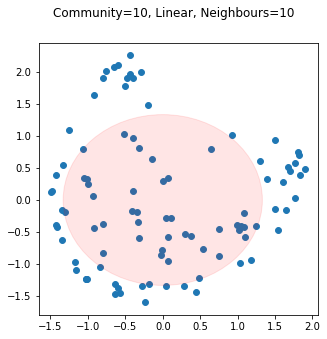

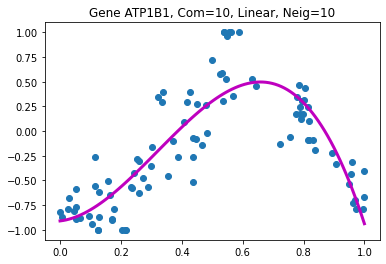

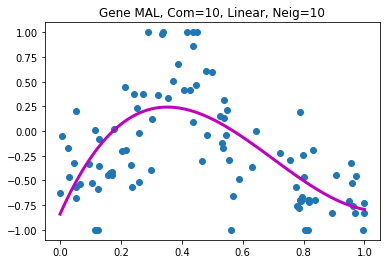

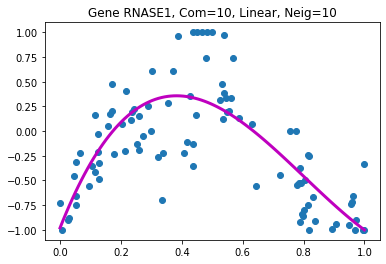

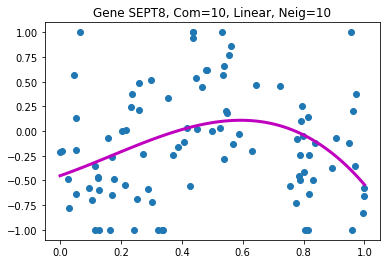

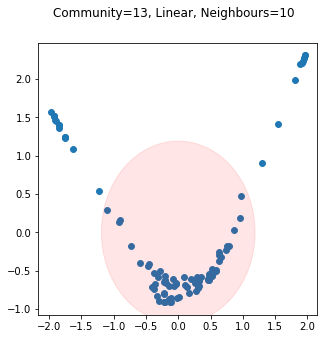

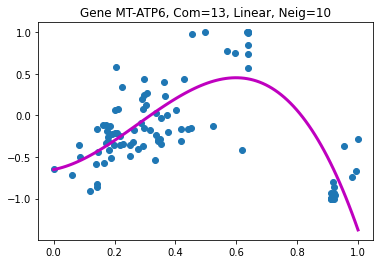

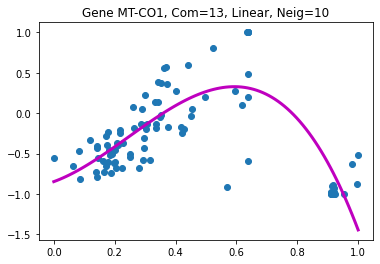

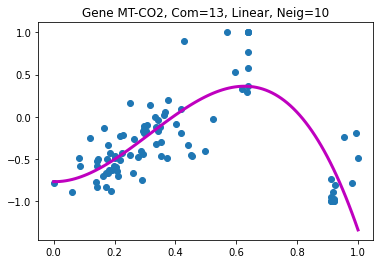

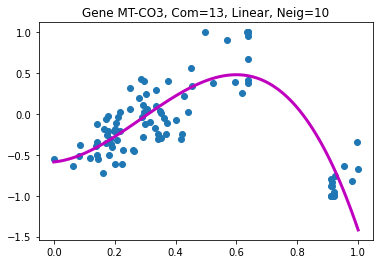

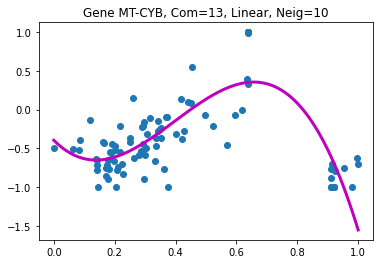

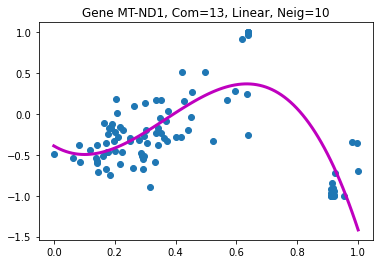

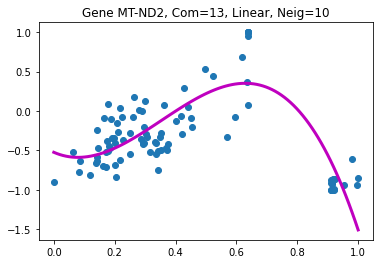

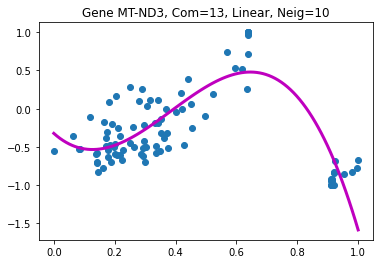

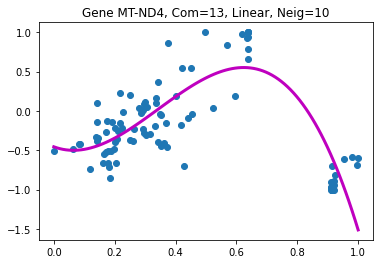

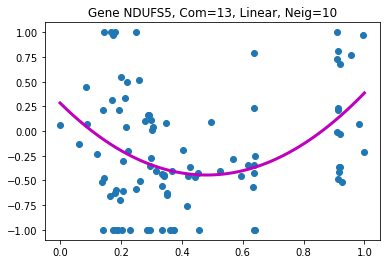

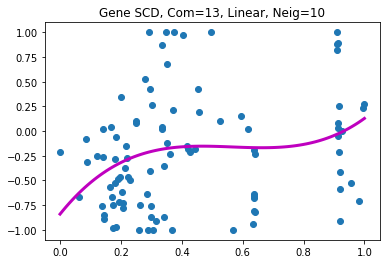

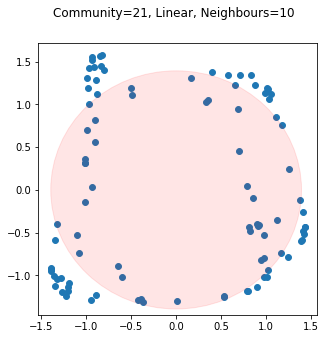

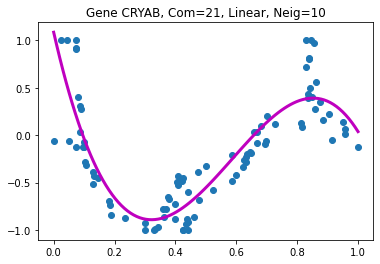

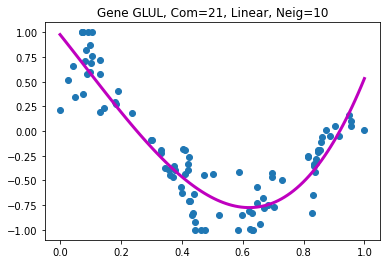

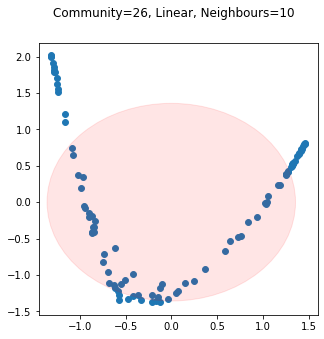

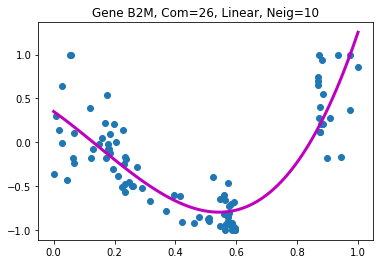

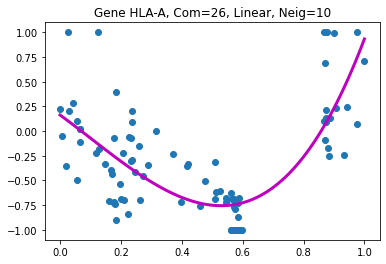

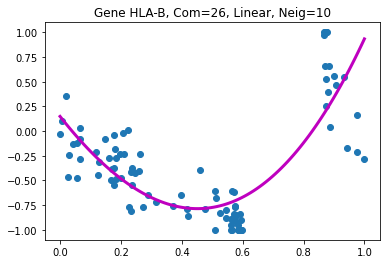

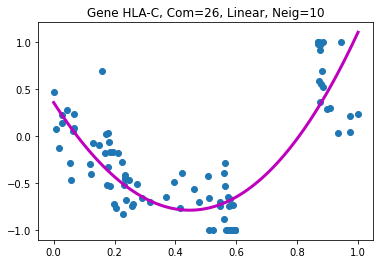

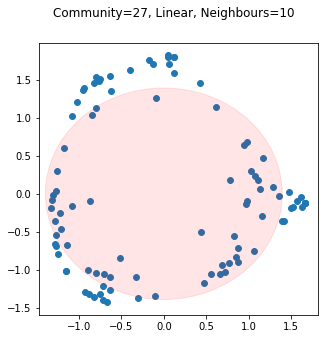

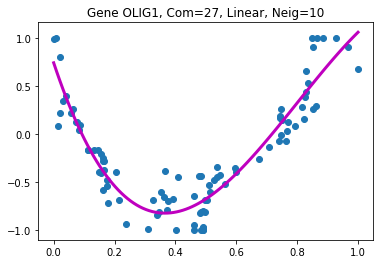

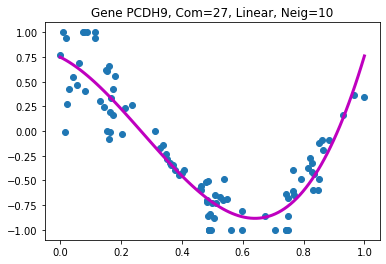

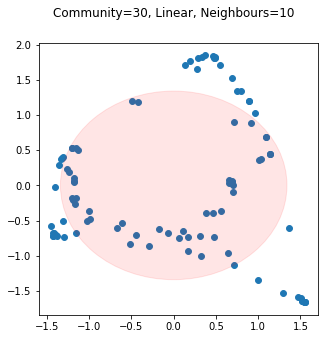

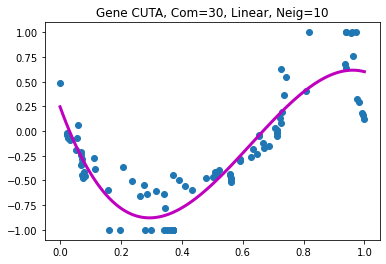

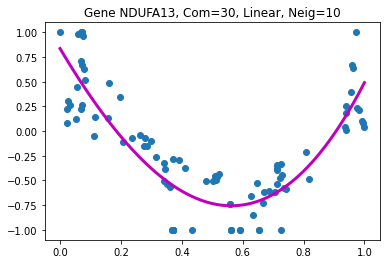

In [91]:
#Start from the linear communities
print('LINEAR COMMUNITIES PLOT')
for commId in LinearId:
    print('Community=')
    print(commId)
    #commId=LinearId[4]
    Flag="Linear"
    comm = commData[commData.CommunityID == commId]
    #select ONLY the genes in the selected community to use laterin the plot
    genelist=comm.index.values
    training_data=data.loc[comm.index] 
    nsamp=training_data.shape[1]
    n_neighbors=math.ceil(nsamp/10)
    n_neighbors
    print('Spectral pseudotime time')
    pt_spectral, latent_space_2d = estimate_pseudotime_using_spectral_embedding(training_data.T, n_neighbors)
    [fig, ax] = plot_latent_space_notrue(latent_space_2d)
    PseudoTimefile=f'{path_to_fig}LinearPseudotime{case}_{alpha}_comm_{commId}.pdf'

    pt = PdfPages(PseudoTimefile)
    fig.suptitle("Community="+str(commId) + ", "+ Flag + ', Neighbours=' +str(n_neighbors))
    fig
    pt.savefig(fig)

    pt.close()
    print('Gene plots')
    geneplot=genelist 
    idx=np.argsort(pt_spectral)
    figfile=f'{path_to_fig}Plotfilter{case}_{alpha}_comm_{commId}.pdf'
    pp = PdfPages(figfile)
    for g in geneplot:
        f=plt.figure()
        gene_series = data.loc[g][idx]
        fspline = UnivariateSpline(pt_spectral[idx], gene_series, check_finite=True)
        xtest = np.linspace(np.min(pt_spectral), np.max(pt_spectral), 100)
        fs = fspline(xtest)
        #plt spline
        plt.plot(xtest, fs, color='m', lw=3);
        #plot data
        plt.scatter(pt_spectral[idx],gene_series)
        plt.title("Gene " + g + ", Com="+str(commId) + ", "+ Flag + ', Neig=' +str(n_neighbors) )
        #f.savefig("commId1.pdf", bbox_inches='tight')
        pp.savefig(f)
    pp.close()

# Get data for the community of interest - Non Linear Case

Community=
1
Community=
2
Community=
3


<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/pseudotime.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f

Community=
4


<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-92-6868990adae3>:29

Community=
5


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/pseudotime.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `

Community=
6


<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


Community=
7


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/pseudotime.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `

Community=
8


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/pseudotime.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `

Community=
9


<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-92-6868990adae3>:29

Community=
11


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/pseudotime.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `

Community=
12


<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


Community=
14


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/pseudotime.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `

Community=
15


<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/pseudotime.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `

Community=
16


<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/pseudotime.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `

Community=
17


<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/pseudotime.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `

Community=
18


<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/pseudotime.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `

Community=
19


<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/pseudotime.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `

Community=
20


<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/pseudotime.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `

Community=
22


<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/pseudotime.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `

Community=
23


<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/pseudotime.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f

Community=
24


<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-92-6868990adae3>:29

Community=
25


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/pseudotime.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `

Community=
28


<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/pseudotime.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f

Community=
29


<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-92-6868990adae3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


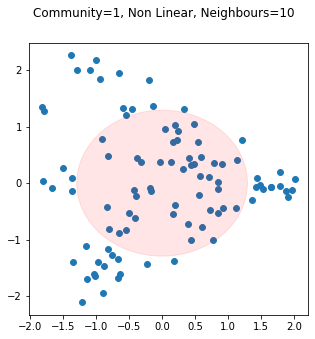

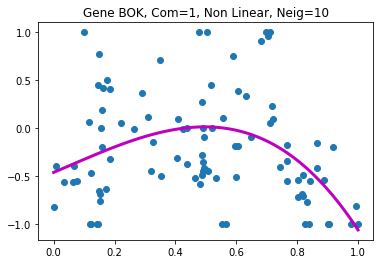

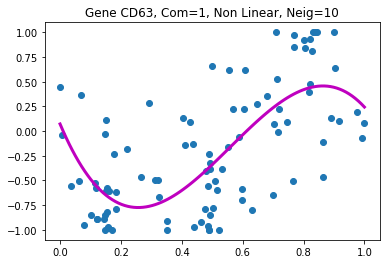

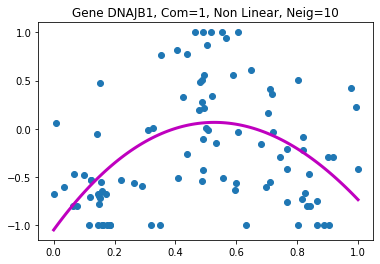

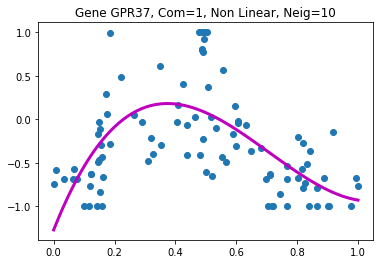

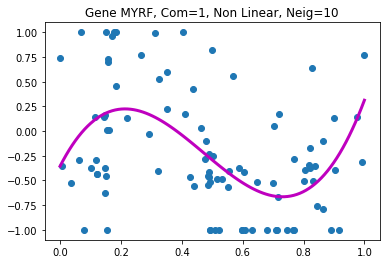

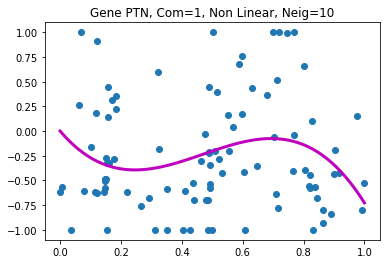

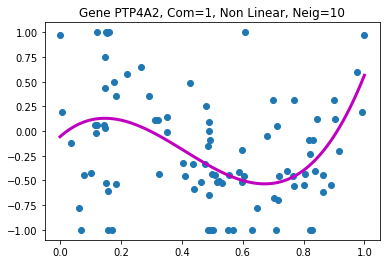

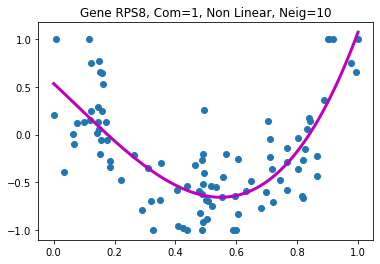

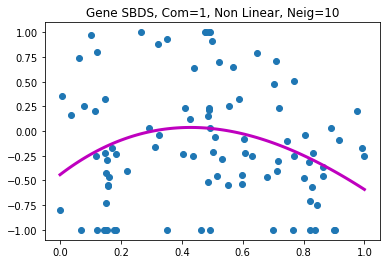

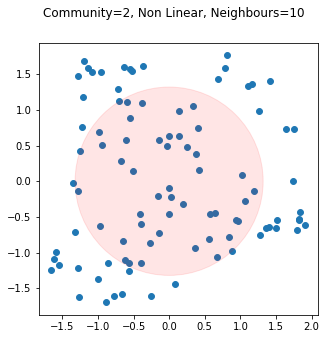

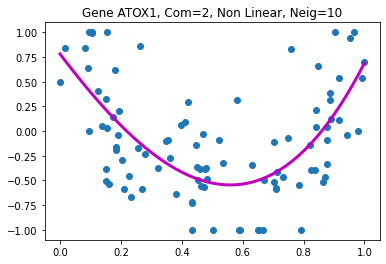

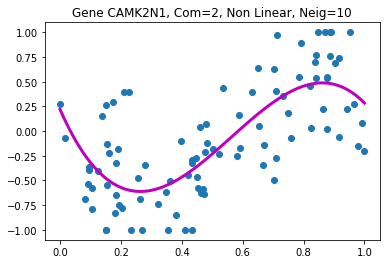

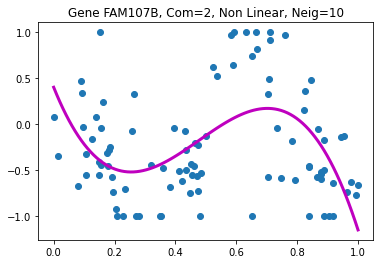

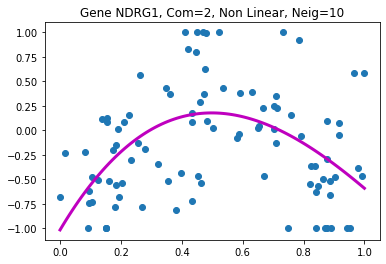

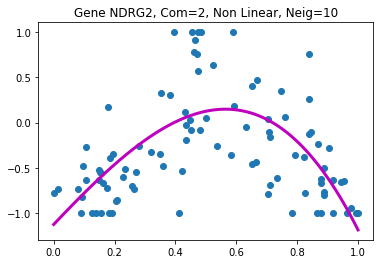

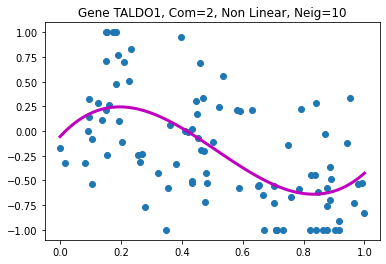

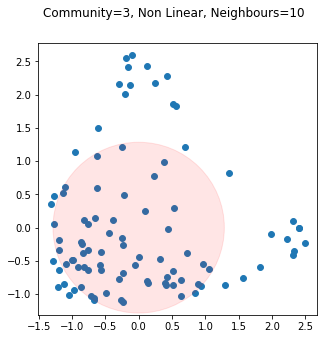

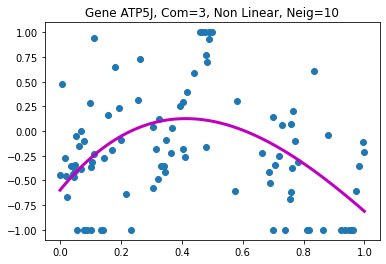

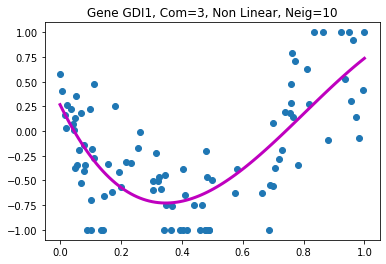

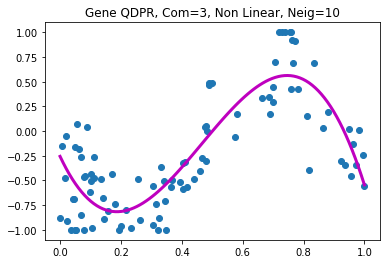

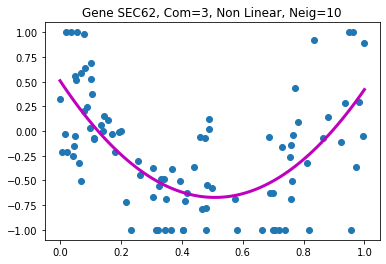

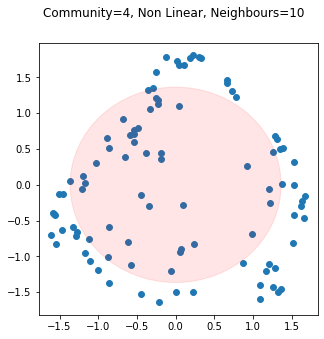

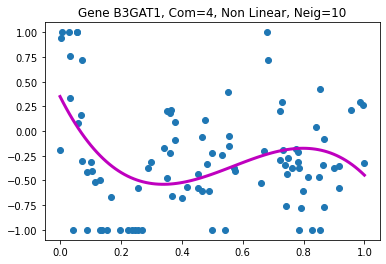

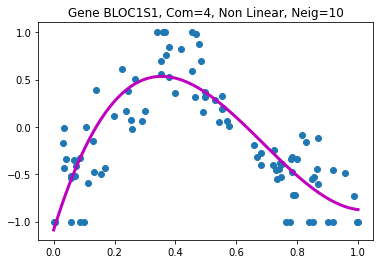

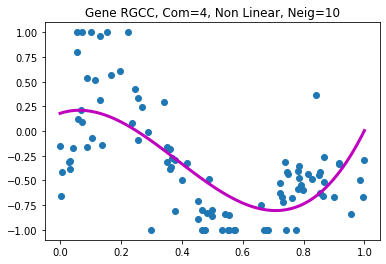

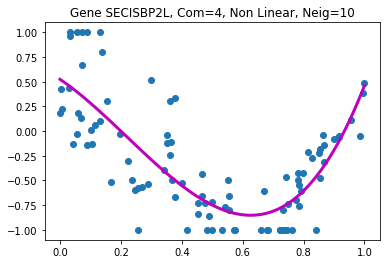

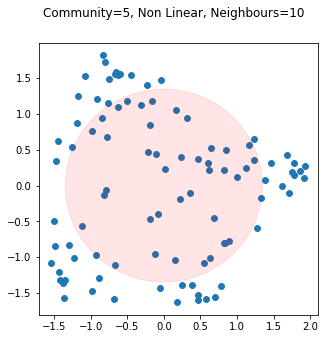

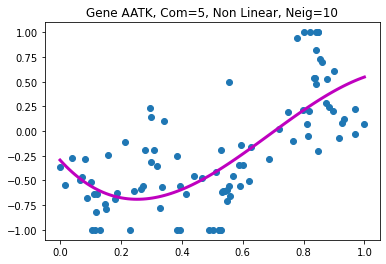

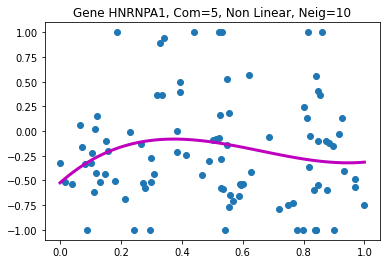

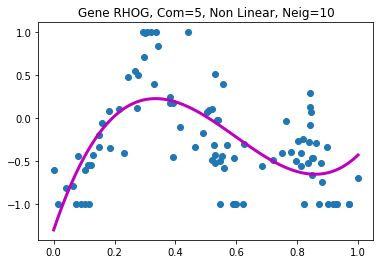

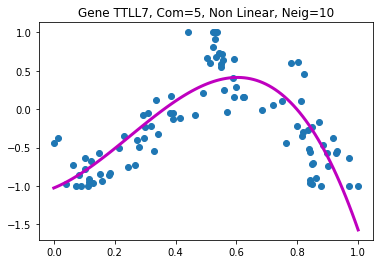

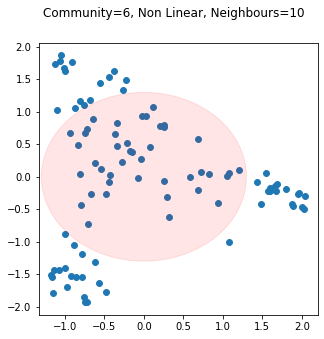

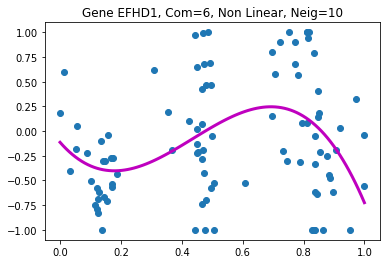

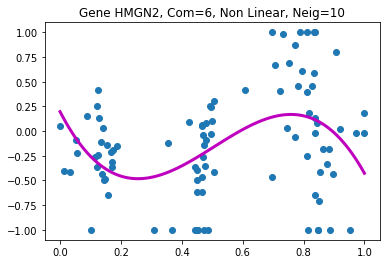

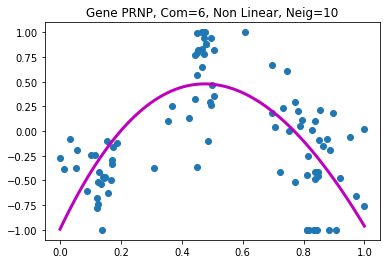

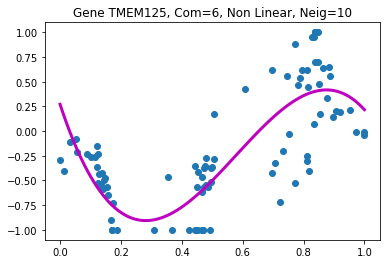

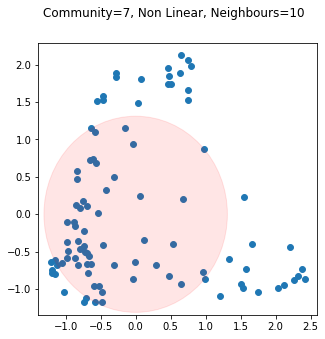

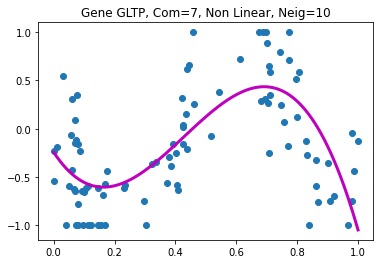

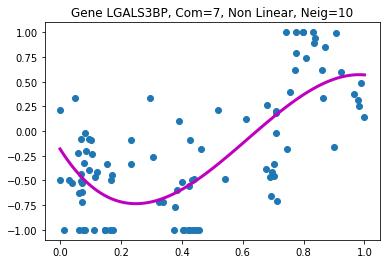

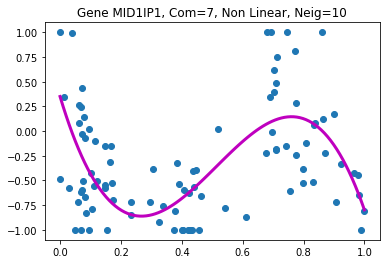

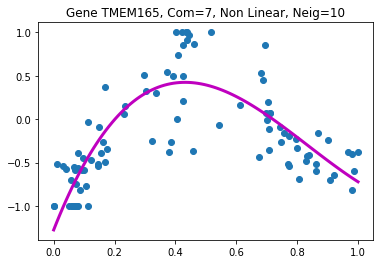

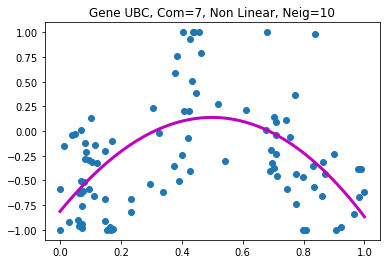

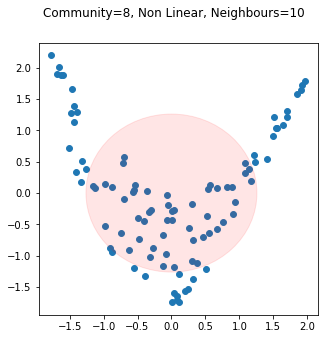

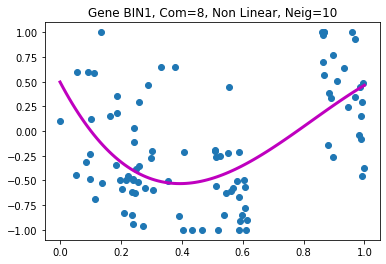

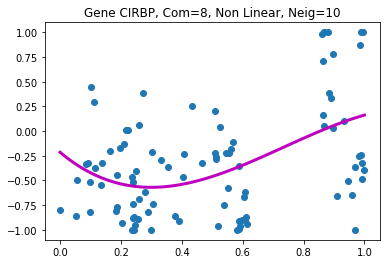

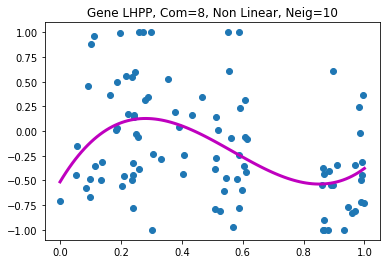

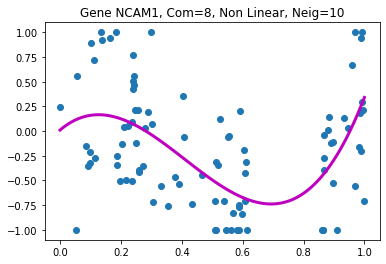

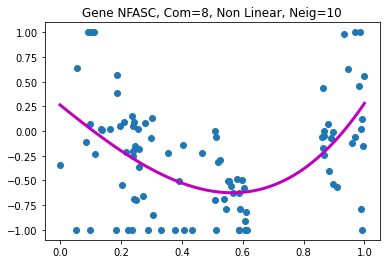

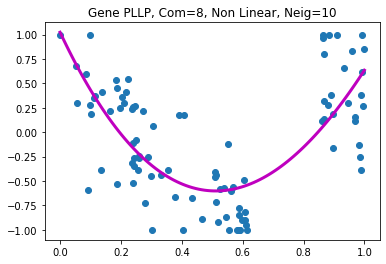

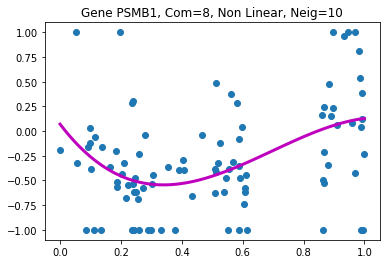

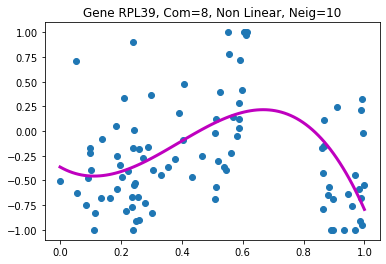

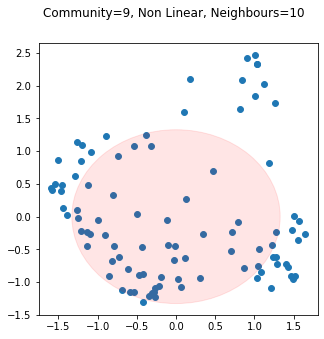

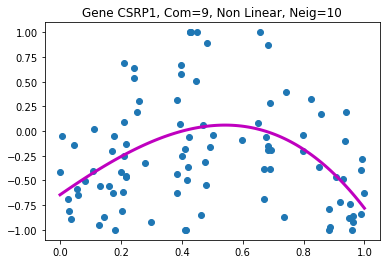

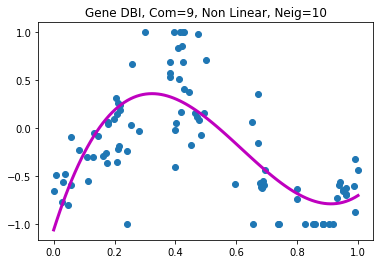

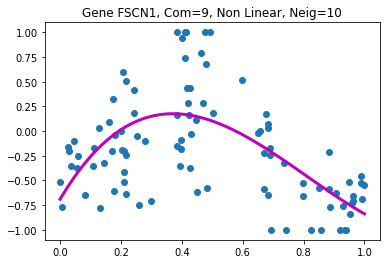

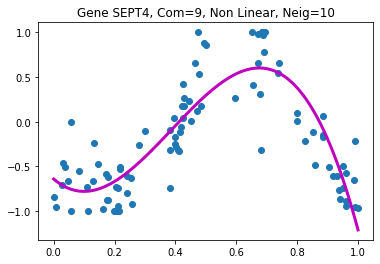

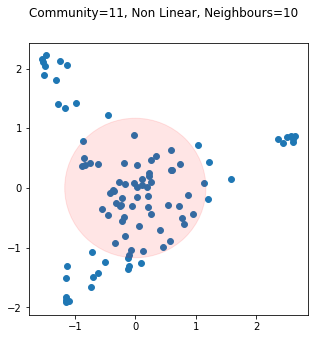

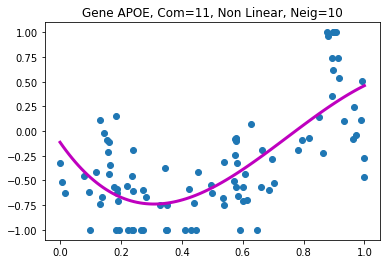

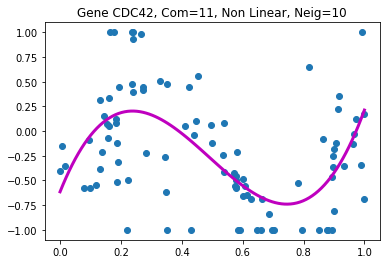

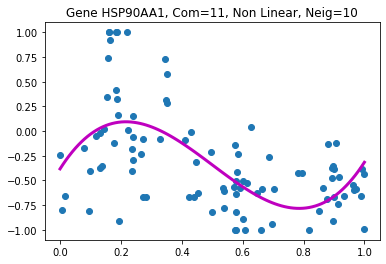

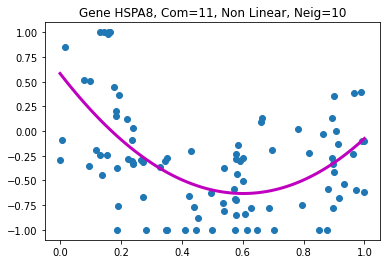

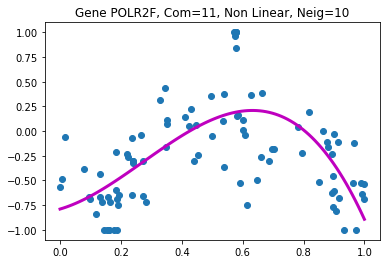

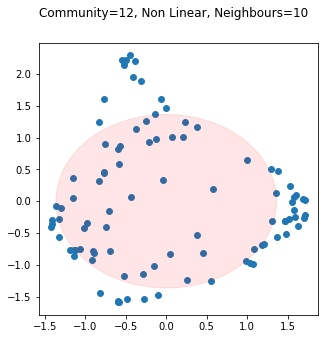

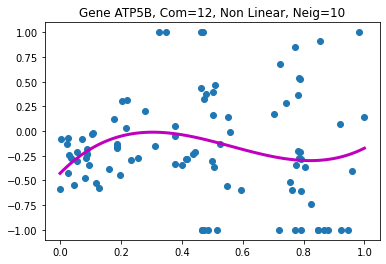

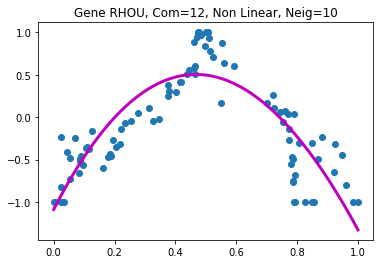

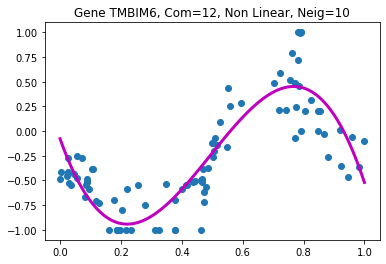

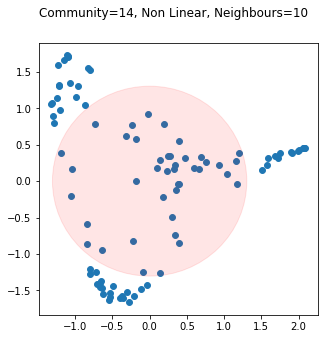

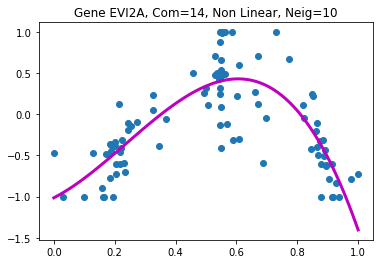

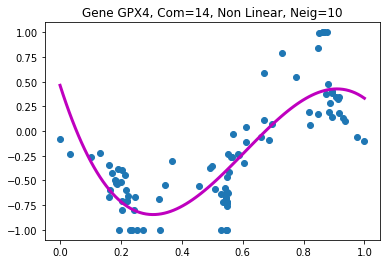

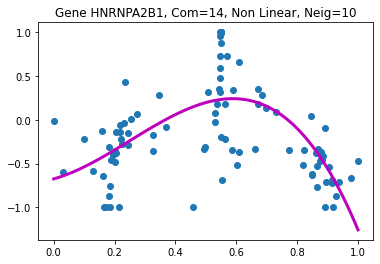

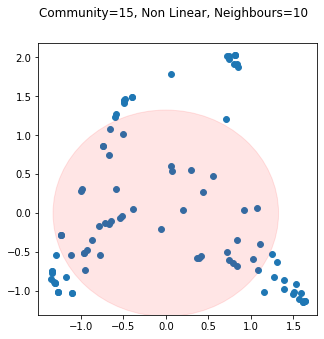

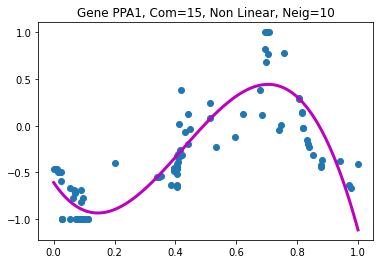

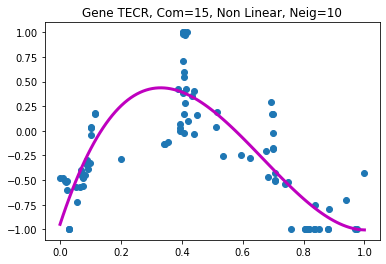

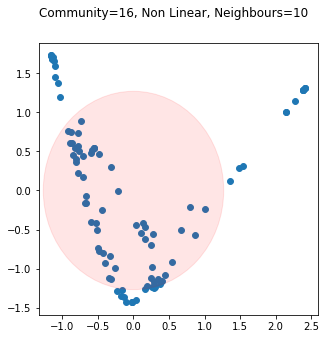

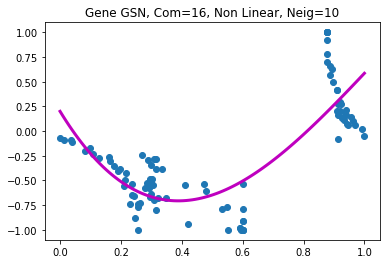

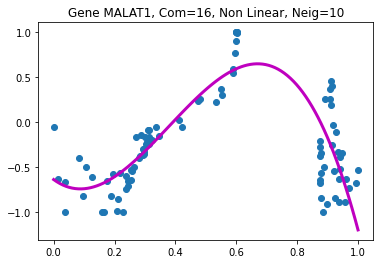

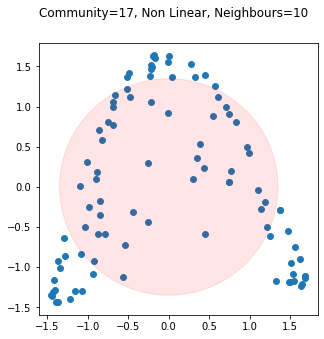

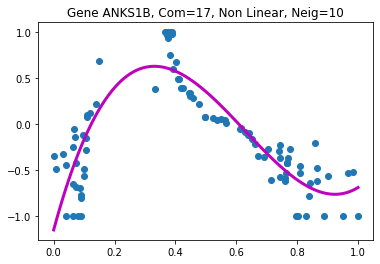

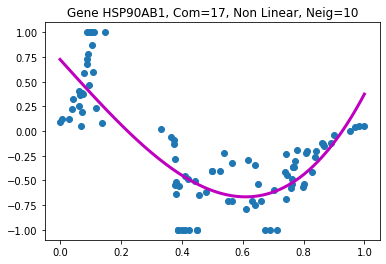

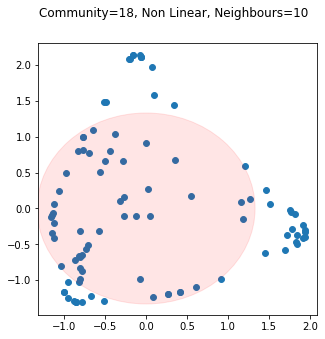

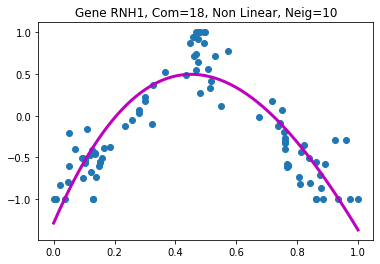

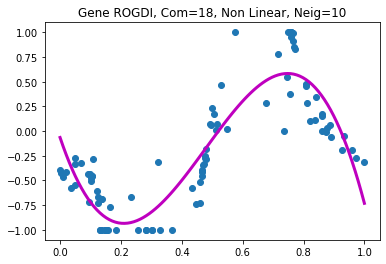

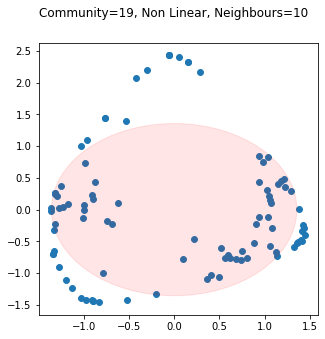

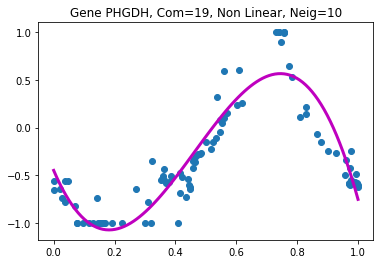

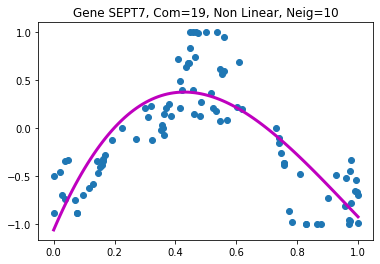

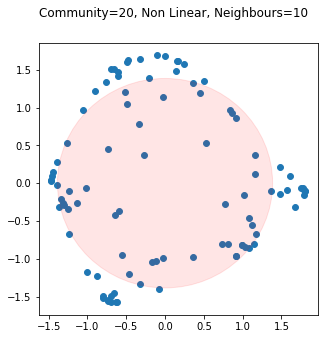

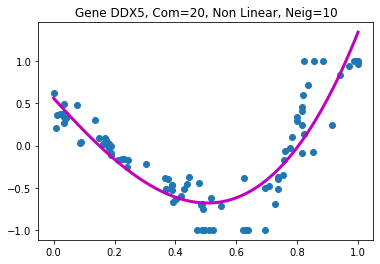

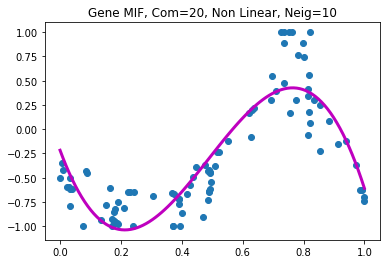

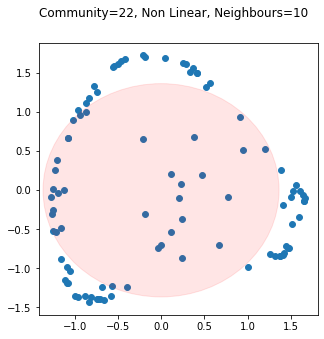

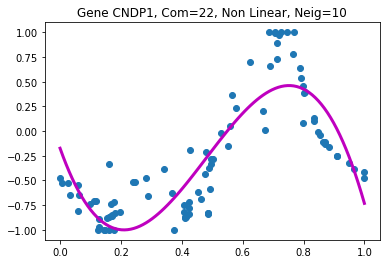

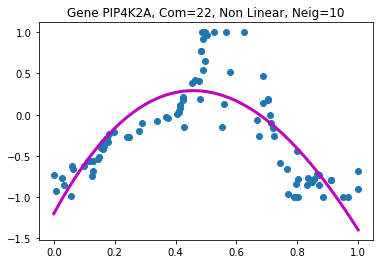

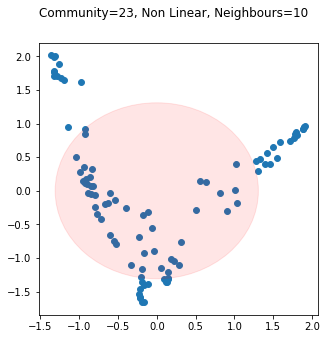

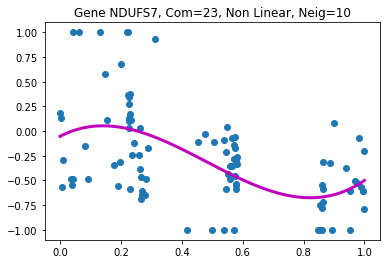

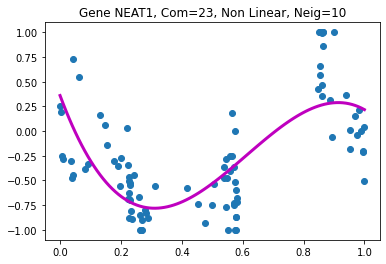

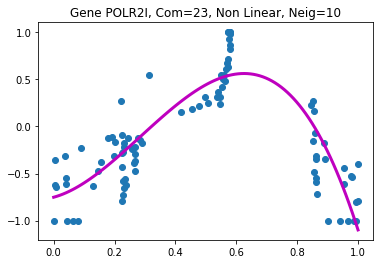

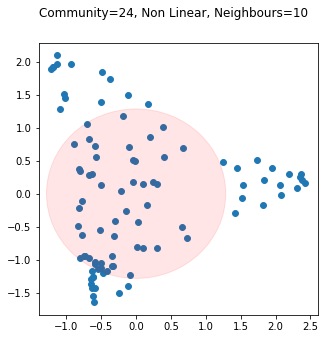

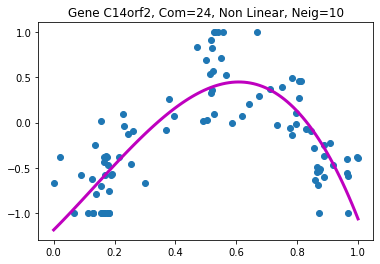

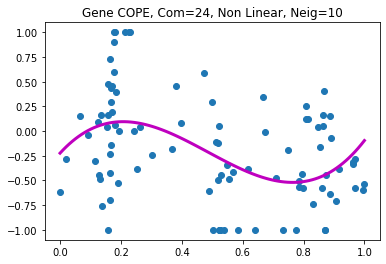

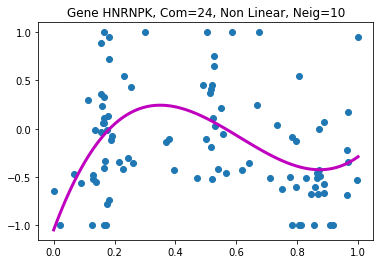

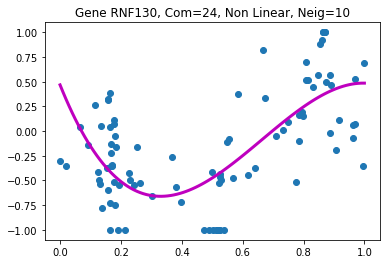

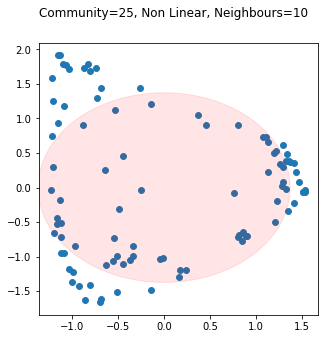

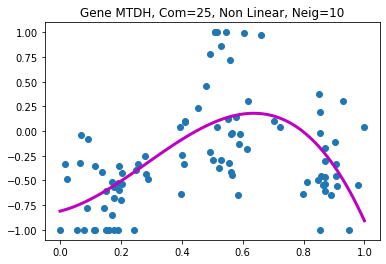

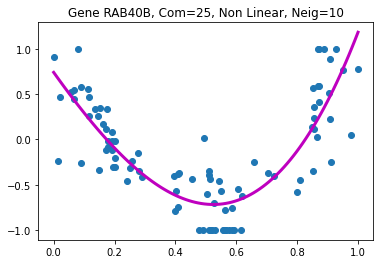

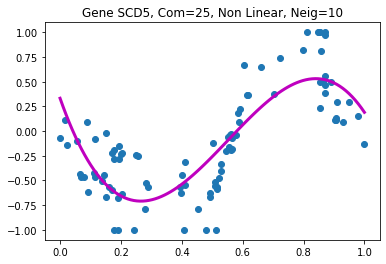

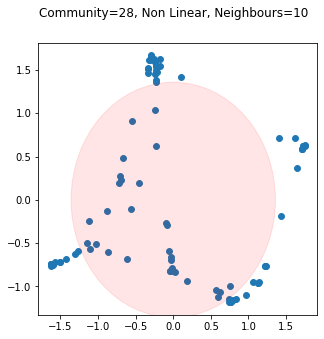

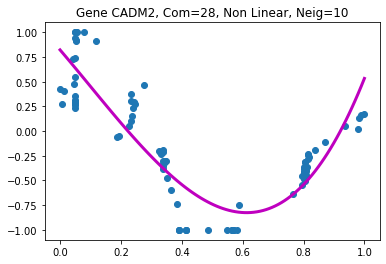

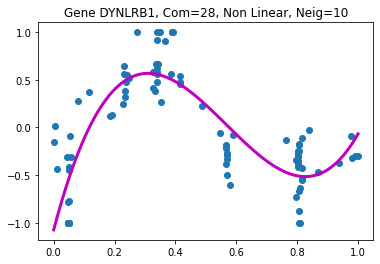

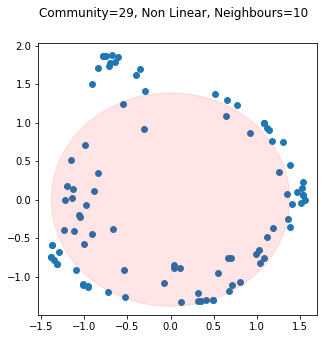

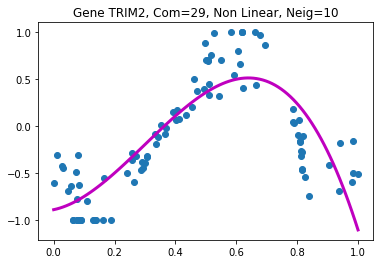

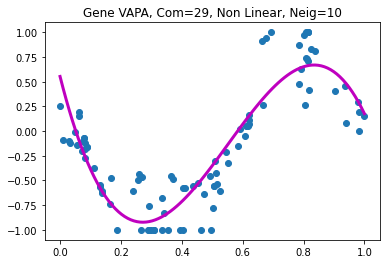

In [92]:
#Start from the linear communities
for commId in NonLinearId:
    print('Community=')
    print(commId)
    #commId=NonLinearId[12]
    Flag="Non Linear"
    comm = commData[commData.CommunityID == commId]
    #select ONLY the genes in the selected community to use laterin the plot
    genelist=comm.index.values
    training_data=data.loc[comm.index]
    nsamp=training_data.shape[1]
    n_neighbors=math.ceil(nsamp/10)
    n_neighbors
    pt_spectral, latent_space_2d = estimate_pseudotime_using_spectral_embedding(training_data.T, n_neighbors)
    [fig, ax] = plot_latent_space_notrue(latent_space_2d)
    PseudoTimefile=f'{path_to_fig}NonLinearPseudotime{case}_{alpha}_comm_{commId}.pdf'
    pt = PdfPages(PseudoTimefile)
    fig.suptitle("Community="+str(commId) + ", "+ Flag + ', Neighbours=' +str(n_neighbors))
    fig
    pt.savefig(fig)
    pt.close()
    #Plot genes
    geneplot=genelist
    idx=np.argsort(pt_spectral)
    figfile=f'{path_to_fig}Plotfilter{case}_{alpha}_comm_{commId}.pdf'
    pp = PdfPages(figfile)
    for g in geneplot:

        f=plt.figure()
        gene_series = data.loc[g][idx]
        fspline = UnivariateSpline(pt_spectral[idx], gene_series, check_finite=True)
        xtest = np.linspace(np.min(pt_spectral), np.max(pt_spectral), 100)
        fs = fspline(xtest)
        #plt spline
        plt.plot(xtest, fs, color='m', lw=3);
        #plot data
        plt.scatter(pt_spectral[idx],gene_series)
        plt.title("Gene " + g + ", Com="+str(commId) + ", "+ Flag + ', Neig=' +str(n_neighbors) )
        pp.savefig(f)
    pp.close()
    
